# What are the chances that Swedens wins it's qualification group? 

## Relevant information: 
* Group teams: Sweden, Switzerland, Kosovo, Slovenien
* Each team plays 6 games in total, 2 against each team. 

## Strategy:

### Step 1 (Match result probability):
* Find a method for determining the probability for each match outcome. Here a simple elo based method could be used.
* Then evaluated by seeing how it performs on historical data
* If it doesn’t perform well go back and implement a more advanced method (like poison goal models, xG-data and ML)

#### Elo and poisson method:
* Calcualte elo in accordance with, https://www.kaggle.com/code/thomasstokes/custom-football-elo-rating
* Fit two linear regression model, where the elo rating difference is fitted to the scored goals of the team, one model for home team and one for away team(this way we can incorporate home advanatge in our model) 
* Then set up a poisson distrubution for expected goals
* Caluculate the probabilities for all match outcomes upp to a max amount of goals
* Then sum all probabilities for the differnet match outcomes—win, loss, draw—and let those sums be the probaility of each match outcome.

#### Evaluation method:

### Step 2(MC simulate Qualification round):
* Run a monte carlo simulation of the group stage and see how many times sweden end on top.


## Load data

In [52]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("martj42/international-football-results-from-1872-to-2017")
df = pd.read_csv(path+"/results.csv")
df2 = pd.read_csv(path+"/shootouts.csv")

print("Last updated: " + df['date'].max())


Last updated: 2025-06-10


## Make elo column

In [71]:

### --- safety measure to make sure that each game is chronological order, changes elo score marginally### ---
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace= True)

### --- dictionary for the penalty shootout games ### ---
df2['date']       = pd.to_datetime(df2['date'])
df2['home_team']  = df2['home_team'].str.strip().str.lower()
df2['away_team']  = df2['away_team'].str.strip().str.lower()
df2['winner']     = df2['winner'].str.strip().str.lower()

penalties = {(d, frozenset({h, a})): w
              for d, h, a, w in zip(df2.date, df2.home_team,
                                    df2.away_team, df2.winner)}

def penalty_winner(date, team_a, team_b):
    return penalties.get((date,frozenset({team_a.lower(), team_b.lower()})))

### --- splitting world cup games into two groups, before quarter finals and after quarter finals ### ---
wc_quarter_final_date = {
    1930: '1930-07-26',     
    1934: '1934-05-31',      
    1938: '1938-06-12',
    1950: None,              
    1954: '1954-06-26',
    1958: '1958-06-19',
    1962: '1962-06-10',
    1966: '1966-07-23',
    1970: '1970-06-14',
    1974: None,         
    1978: None,              
    1982: None,              
    1986: '1986-06-21',
    1990: '1990-06-30',
    1994: '1994-07-02',
    1998: '1998-07-03',
    2002: '2002-06-21',
    2006: '2006-06-30',
    2010: '2010-07-02',
    2014: '2014-07-04',
    2018: '2018-07-06',
    2022: '2022-12-09'
}
wc_quarter_final_date = {year: (None if dt is None else pd.to_datetime(dt))
                         for year, dt in wc_quarter_final_date.items()}

### --- Elo functions --- ###
def calculate_team_a_expected_result(a_elo,b_elo):
    return 1 / (1 + pow(10,-(a_elo-b_elo)/600)) ##600

def update_elo_draw(a_elo, b_elo, i):
    w = 0.5

    new_a_elo = a_elo + i*(w - calculate_team_a_expected_result(a_elo, b_elo))
    new_b_elo = b_elo + i*(w - calculate_team_a_expected_result(b_elo,a_elo))
    return (new_a_elo, new_b_elo)

def update_elo_win(win_elo, loss_elo, i):
    w_win = 1
    w_loss = 0

    new_win_elo = win_elo + i*(w_win - calculate_team_a_expected_result(win_elo, loss_elo))
    new_loss_elo = loss_elo + i*(w_loss - calculate_team_a_expected_result(loss_elo,win_elo))
    return (new_win_elo, new_loss_elo)

### --- only for the games that went to penalties ### ---
def update_elo_penalties(win_elo, loss_elo,i):
    w_win = 0.75
    w_loss = 0.5

    new_win_elo = win_elo + i * (w_win - calculate_team_a_expected_result(win_elo, loss_elo))
    new_loss_elo = loss_elo + i *(w_loss - calculate_team_a_expected_result(loss_elo,win_elo))
    return (new_win_elo, new_loss_elo)


### --- Append importance column --- ###
df['tournament'].str.lower().unique() #just to check all the unique games, printable
friendlies = ['friendly']
nations_league = ['uefa nations league']
qualifications = ['fifa world cup qualification', 'afc asian cup qualification', 'copa américa qualification',
                   'uefa euro qualification', 'concacaf championship qualification', 'african cup of nations qualification']
confederation_finals = ['copa américa', 'uefa euro', 'african cup of nations', 'concacaf championship', 'afc asian cup', 
        'oceania nations cup', 'confederations cup']
world_cup = ['fifa world cup']

#retrieve match type and assign importance of game based on the match partitioning above
def game_importance_score(row):
    tournament = row['tournament'].lower()
    
    if tournament in friendlies:
        return 10 if  row.date.month in [3,6,9,10,11] else 5

    if tournament in nations_league:
        return 15
    
    if tournament in qualifications:
        return 25

    if tournament in confederation_finals:
        return 35
    
    if tournament in world_cup:
        quarter_finals = wc_quarter_final_date.get(row.date.year)
        if quarter_finals == None:
            return 60
        return 50 if row.date  < quarter_finals else 60

    
    return 1 #15

df['importance'] = df.apply(game_importance_score, axis = 1)


### --- Append elo columns --- ###
all_countries = pd.unique(pd.concat([df['home_team'], df['away_team']]))
elo_home = []
elo_away = []
elo_diff = []

current_elo = {}
for country in all_countries:
    current_elo[country] = 1000 #1000


for index,row in df.iterrows():
    home_team = row.home_team
    away_team = row.away_team
    home_score = row.home_score
    away_score = row.away_score
    i = row.importance           ## faster than using game_importance_score(row)
    score_diff = home_score-away_score
    
    home_current_elo = current_elo[home_team]
    away_current_elo = current_elo[away_team]
    current_elo_diff = home_current_elo-away_current_elo

    home_win = (score_diff)>0
    if (score_diff)>0:
        (new_home_elo, new_away_elo) = update_elo_win(home_current_elo,away_current_elo,i) 
    elif (score_diff)==0:
        winner = penalty_winner(row.date, home_team, away_team)
        if winner is None:
            (new_home_elo, new_away_elo) = update_elo_draw(home_current_elo,away_current_elo,i)
        elif winner == home_team.lower():
            (new_home_elo,new_away_elo) = update_elo_penalties(home_current_elo, away_current_elo,i)
        else:
            (new_away_elo, new_home_elo) = update_elo_penalties(away_current_elo,home_current_elo,i)

    else:
        (new_away_elo, new_home_elo) = update_elo_win(away_current_elo,home_current_elo,i)

    # Update elo
    current_elo[home_team] = new_home_elo
    current_elo[away_team] = new_away_elo
    elo_home.append(new_home_elo)
    elo_away.append(new_away_elo)
    elo_diff.append(current_elo_diff)


df['home_elo'] = elo_home
df['away_elo'] = elo_away
df['elo_diff'] = elo_diff
df['score_diff'] = df['home_score']-df['away_score']

print('New columns info:')
print('* The new columns "home_elo" and "away_elo" represents the elo scorce each team recived after the match')
print('* The new columns "elo_dff" represents the elo difference befrore the match(home_elo-away_elo)')
print('* The new columns "score_dff" represents the score difference(home_elo-away_elo)')
print('* The new columns "importance" represents a quantification of the importance of match')
print('')
print(df.head(5))

New columns info:
* The new columns "home_elo" and "away_elo" represents the elo scorce each team recived after the match
* The new columns "elo_dff" represents the elo difference befrore the match(home_elo-away_elo)
* The new columns "score_dff" represents the score difference(home_elo-away_elo)
* The new columns "importance" represents a quantification of the importance of match

        date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1 1873-03-08   England  Scotland           4           2   Friendly   London   
2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3 1875-03-06   England  Scotland           2           2   Friendly   London   
4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  importance     home_elo     away_elo   elo_diff  \
0  Scotland    False          10  1000.000000  1000.000000   

#### List current elo in descending order

In [74]:

countries = list(current_elo.keys())
elo = list(current_elo.values())
df_current_elo = pd.DataFrame(data={'Country': countries, 'Elo': elo})

print(df_current_elo.sort_values('Elo', ascending=False).head(12))

        Country          Elo
8     Argentina  1647.620347
35        Spain  1639.675534
10       France  1609.165781
31       Brazil  1541.769730
1       England  1520.090519
13  Netherlands  1502.249730
19      Germany  1500.820697
49     Portugal  1496.917968
20        Italy  1449.713207
9       Belgium  1443.999530
32        Japan  1441.083571
84      Croatia  1428.910317


## Fit linear regression model

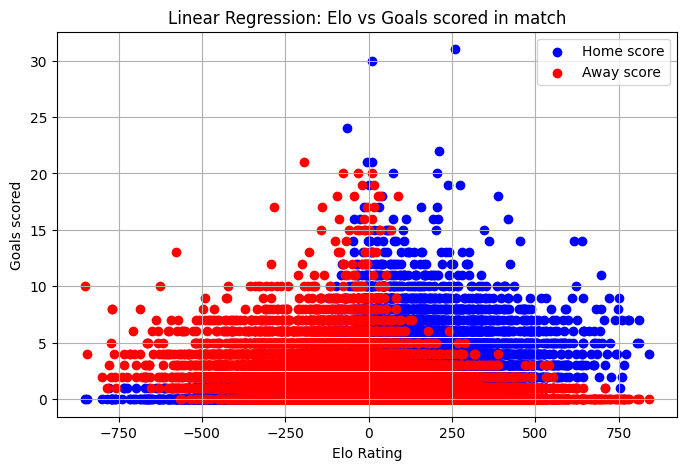

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### IMPROVEMENT: Consider removing some of the first matches since the elo rating has not stabilized 
X = df[['elo_diff']]

y_home = df['home_score']
y_away = df['away_score']

plt.figure(figsize=(8, 5))
plt.scatter(X, y_home, color='blue', label='Home score')
plt.scatter(X, y_away, color='red', label='Away score')

plt.xlabel('Elo Rating')
plt.ylabel('Goals scored')
plt.title('Linear Regression: Elo vs Goals scored in match')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Train model
X_train, X_test, y_train_h, y_test_h = train_test_split(X, y_home, test_size=0.2, random_state=30)
X_train, X_test, y_train_a, y_test_a = train_test_split(X, y_away, test_size=0.2, random_state=30)

model_h = LinearRegression()
model_a = LinearRegression()
model_h.fit(X_train, y_train_h)
model_a.fit(X_train, y_train_a)


#### Model result

-------- Prediction metrics --------
Coefficients: [-0.00263729]
Intercept: 1.2047656543172864
R² Score: 0.09646114585956478
RMSE: 1.3415263007577967
-------- Plot --------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


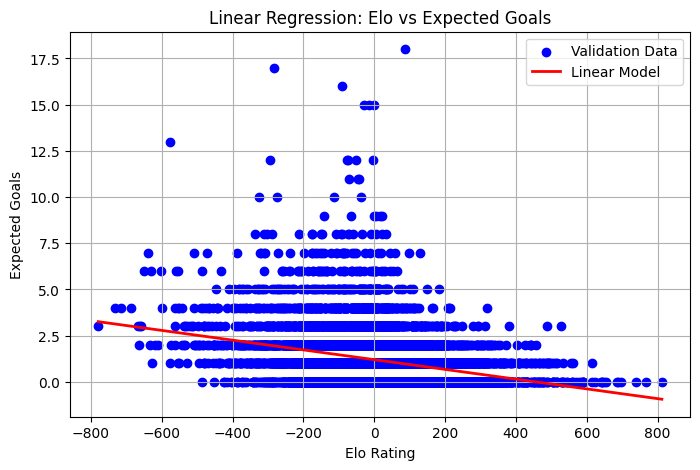

In [55]:
select_model = "Away" #Select model

if select_model == "Home":
    model = model_h 
    y_test = y_test_h
else:
    model = model_a 
    y_test = y_test_a

y_pred = model.predict(X_test)


print('-------- Prediction metrics --------')
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print('-------- Plot --------')
# Create a smooth line for the regression
elo_range = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
line_pred = model.predict(elo_range)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Validation Data')
plt.plot(elo_range, line_pred, color='red', linewidth=2, label='Linear Model')

plt.xlabel('Elo Rating')
plt.ylabel('Expected Goals')
plt.title('Linear Regression: Elo vs Expected Goals')
plt.legend()
plt.grid(True)
plt.show()


#### Comment:
Now that we have a estimate of expected goals based on elo difference we can make the math result prediction, using poission distrubution

## Step 1:

### Determing match result probaility:

#### Match result function

In [76]:
import math
MAX_GOALS = 15

# PMF: Probability Mass Function 
# k = Number of goals
# lamda = Number of expected goals
def poisson_pmf(k, lam):
    return (lam**k * math.exp(-lam)) / math.factorial(k)

def get_match_res_prob(lambda_home,lambda_away):
    prob_home_win = 0
    prob_draw = 0
    prob_home_loss = 0

    for h_goals in range(0,MAX_GOALS):
        for a_goals in range(0,MAX_GOALS):
            prob_home_goals = poisson_pmf(h_goals, lambda_home)
            prob_away_goals = poisson_pmf(a_goals, lambda_away)
            prob_outcome = prob_home_goals*prob_away_goals
            if h_goals > a_goals:
                prob_home_win += prob_outcome
            elif h_goals == a_goals:
                prob_draw += prob_outcome
            else:
                prob_home_loss += prob_outcome
                
    return (prob_home_win, prob_draw, prob_home_loss)


In [88]:
test_match = df[df['home_team']=='Sweden'].iloc[500]
print(f'Home: {test_match.home_team}, Away: {test_match.away_team}, Date: {test_match.date}')
print('')

lambda_h = model_h.predict([[test_match.elo_diff]])
lambda_a = model_a.predict([[test_match.elo_diff]])

(prob_home_win, prob_draw, prob_home_loss) = get_match_res_prob(lambda_home=lambda_h, lambda_away=lambda_a)

print(f'Home team: Win({prob_home_win}), Draw({prob_draw}), Loss({prob_home_loss}) ')
print(f'Sum: {prob_home_win+prob_draw+prob_home_loss }')

Home: Sweden, Away: Armenia, Date: 2021-06-05

Home team: Win([0.86400943]), Draw([0.10193074]), Loss([0.03405953]) 
Sum: [0.99999971]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/t1/lwk69s1x2ld0fk2ftj75_5h80000gn/T/ipykernel_42171/3573297394.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (lam**k * math.exp(-lam)) / math.factorial(k)


## Step 2:

In [91]:
group_b_matches = { 'Home Team': 
['Slovenia', 'Switzerland', 'Kosovo', 'Switzerland', 'Kosovo', 'Sweden', 'Slovenia', 'Sweden', 'Slovenia', 'Switzerland',
 'Kosovo', 'Sweden' ],
'Away Team': ['Sweden', 'Kosovo', 'Sweden', 'Slovenia', 'Slovenia', 'Switzerland', 'Switzerland', 'Kosovo', 'Kosovo', 'Sweden', 
'Switzerland', 'Slovenia']    
 }

df_group_b = pd.DataFrame(data=group_b_matches)

print(df_group_b)

      Home Team    Away Team
0      Slovenia       Sweden
1   Switzerland       Kosovo
2        Kosovo       Sweden
3   Switzerland     Slovenia
4        Kosovo     Slovenia
5        Sweden  Switzerland
6      Slovenia  Switzerland
7        Sweden       Kosovo
8      Slovenia       Kosovo
9   Switzerland       Sweden
10       Kosovo  Switzerland
11       Sweden     Slovenia
